# Our Ising 2D

We reproduce here the minimal freely available code for Ising simulation in Python provided Rajesh Singh,  Indian Institute of Technology (IIT) Madras. 

https://rajeshrinet.github.io/blog/2014/ising-model/


It is your starting point for a more complete and efficient implementation. 


In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
from numba import njit

In [ ]:
#----------------------------------------------------------------------
##  BLOCK OF FUNCTIONS USED IN THE MAIN CODE
#----------------------------------------------------------------------
def initialstate(N):   
    ''' generates a random spin configuration for initial condition'''
    state = 2*np.random.randint(2, size=(N,N))-1
    return state

@njit(fastmath = True)
def mcmove(config, beta):
    '''Monte Carlo move using Metropolis algorithm '''
    for i in range(N):
        for j in range(N):
                a = np.random.randint(0, N)
                b = np.random.randint(0, N)
                s =  config[a, b]
                nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
                cost = 2*s*nb
                if cost < 0:
                    s *= -1
                elif rand() < np.exp(-cost*beta):
                    s *= -1
                config[a, b] = s
    return config


@njit(fastmath = True)
def calcEnergy(config):
    '''Energy of a given configuration'''
    energy = 0
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i,j]
            nb = config[(i+1)%N, j] + config[i,(j+1)%N] + config[(i-1)%N, j] + config[i,(j-1)%N]
            energy += -nb*S
    return energy/4.


def calcMag(config):
    '''Magnetization of a given configuration'''
    mag = np.sum(config)
    return mag

In [56]:
## change these parameters for a smaller (faster) simulation 
nt      = 3000         #  number of temperature points
N       = 80         #  size of the lattice, N x N
eqSteps = 1024       #  number of MC sweeps for equilibration
mcSteps = 1024       #  number of MC sweeps for calculation

T       = np.linspace(1.53, 3.28, nt); 
E,M,C,X = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)
n1, n2  = 1.0/(mcSteps*N*N), 1.0/(mcSteps*mcSteps*N*N) 
# divide by number of samples, and by system size to get intensive values

In [ ]:
#----------------------------------------------------------------------
#  MAIN PART OF THE CODE
#----------------------------------------------------------------------
for tt in range(nt):
    E1 = M1 = E2 = M2 = 0
    config = initialstate(N)
    iT=1.0/T[tt]; iT2=iT*iT;
    
    for i in range(eqSteps):         # equilibrate
        mcmove(config, iT)           # Monte Carlo moves

    for i in range(mcSteps):
        mcmove(config, iT)           
        Ene = calcEnergy(config)     # calculate the energy
        Mag = calcMag(config)        # calculate the magnetisation

        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag*Mag 
        E2 = E2 + Ene*Ene

    E[tt] = n1*E1
    M[tt] = n1*M1
    C[tt] = (n1*E2 - n2*E1*E1)*iT2
    X[tt] = (n1*M2 - n2*M1*M1)*iT


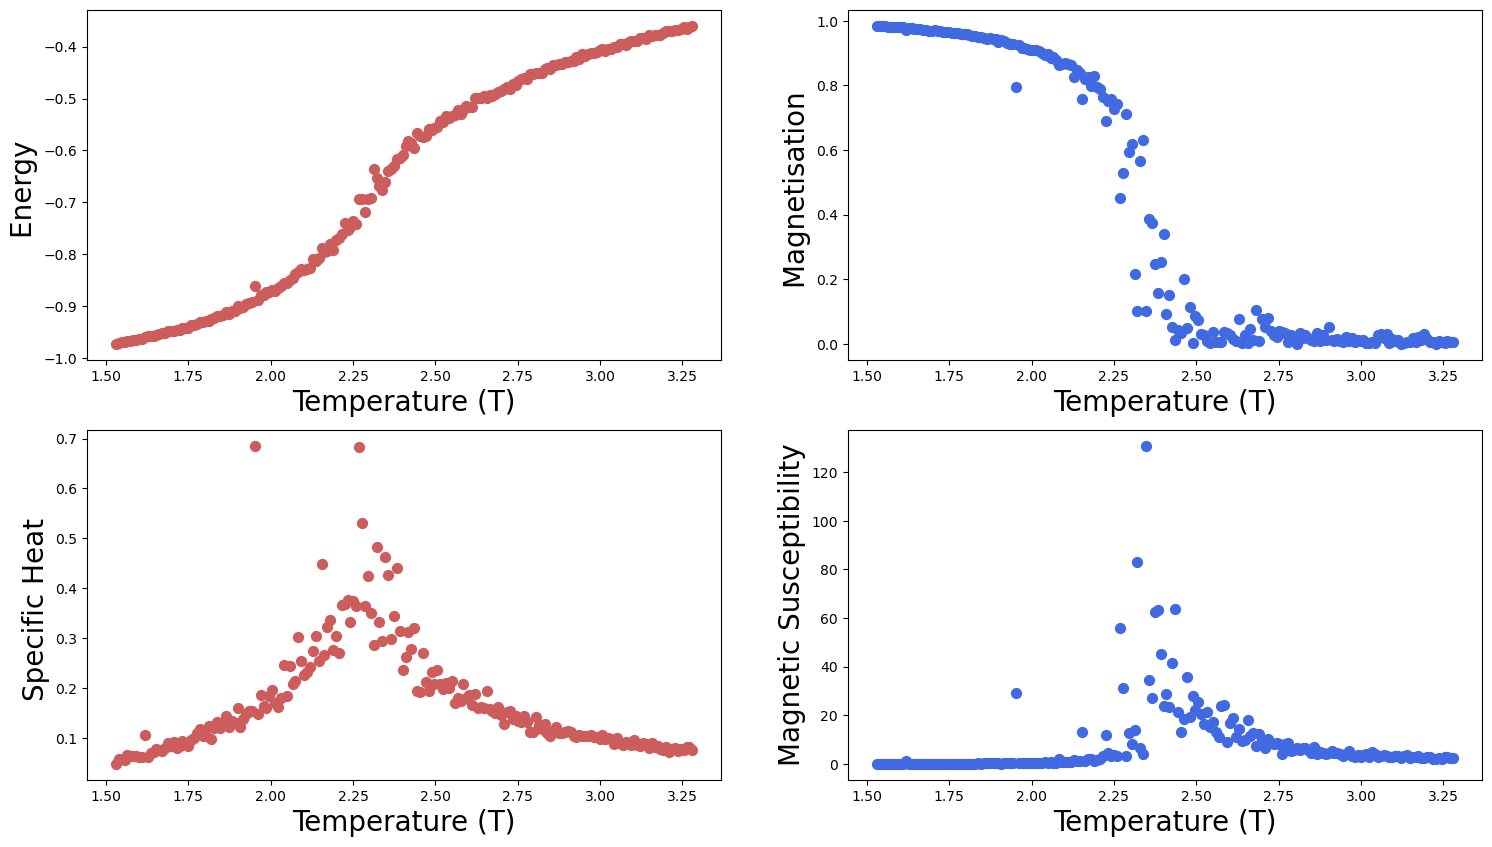

In [5]:
f = plt.figure(figsize=(18, 10)); # plot the calculated values    

sp =  f.add_subplot(2, 2, 1 );
plt.scatter(T, E, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');

sp =  f.add_subplot(2, 2, 2 );
plt.scatter(T, abs(M), s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetisation ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(2, 2, 3 );
plt.scatter(T, C, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);  
plt.ylabel("Specific Heat ", fontsize=20);   plt.axis('tight');   

sp =  f.add_subplot(2, 2, 4 );
plt.scatter(T, X, s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetic Susceptibility", fontsize=20);   plt.axis('tight');

In [28]:
from scipy.optimize import curve_fit

def susc_model(T, A, Tc, gamma):
    return A * np.power(T-Tc, -gamma)

max_susc = np.argmax(X)
model_susc = X[max_susc+5:]
model_temp = T[max_susc+5:]
print(model_susc)
print(model_temp)

initial_guesses = [1.0,2.2,1.5]

params, covariance = curve_fit(susc_model, model_temp, model_susc, p0=initial_guesses)
A_fit, Tc_fit, gamma_fit = params

print(f"Extracted Tc: {Tc_fit:.4f}")
print(f"Extracted Gamma: {gamma_fit:.4f}")

# T_smooth = np.linspace(model_temp.min(), model_temp.max(), 500)
# chi_smooth = susc_model(T_smooth, A_fit, Tc_fit, gamma_fit)

# plt.scatter(model_temp, model_susc, color='red', label='Data Points', zorder=5)
# plt.plot(T_smooth, chi_smooth, color='blue', 
        #  label=f'Fit: $T_c={Tc_fit:.3f}$, $\gamma={gamma_fit:.3f}$')

# plt.xlabel('Temperature ($T$)')
# plt.ylabel('Susceptibility ($\chi$)')
# plt.title('Power-Law Fit for Ising Model Criticality')
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.savefig('ising_fit_plot.png')


[0.39176968 0.43573286 2.53883372 ... 0.11523977 0.10107195 0.10257284]
[2.29075538 2.29163082 2.29250625 ... 3.27824912 3.27912456 3.28      ]


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [27]:
imax = np.argmax(X)

skip = 3

 

Tfit = T[imax+skip:]

Xfit = X[imax+skip:]

 

def fit_for_Tc(Tc_trial):

    y = np.log(Xfit)

    x = np.log(Tfit - Tc_trial)

    a, b = np.polyfit(x, y, 1)

    gamma = -a

    A = np.exp(b)

    yfit = b + a*x

    err = np.mean((y - yfit)**2)

    return err, A, gamma

 

Tc_scan = np.linspace(min(Tfit)-0.5, min(Tfit)-1e-4, 2000)

 

best = None

for Tc_trial in Tc_scan:

    if np.any(Tfit - Tc_trial <= 0):

        continue

    err, A, gamma = fit_for_Tc(Tc_trial)

    if best is None or err < best[0]:

        best = (err, Tc_trial, A, gamma)

 

err, Tc_fit, A_fit, gamma_fit = best

 

print("Tc =", Tc_fit)

print("gamma =", gamma_fit)

Tc = 1.7890045022511254
gamma = 2.529440813033303


# Code to find gamma with Binding Cumulant 

Tc from Binder minimum: 2.6574
Tc from susc peak:     2.3178
Exact 2D Ising Tc:     2.2690


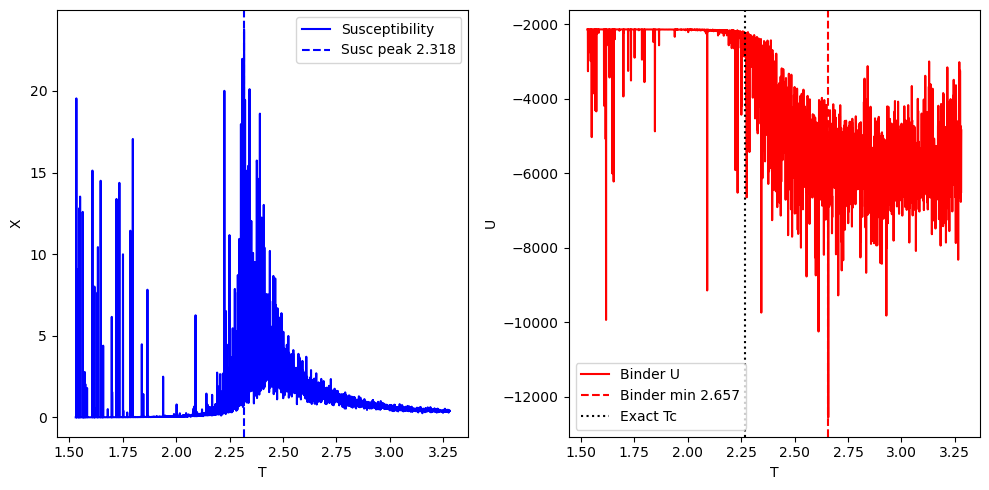

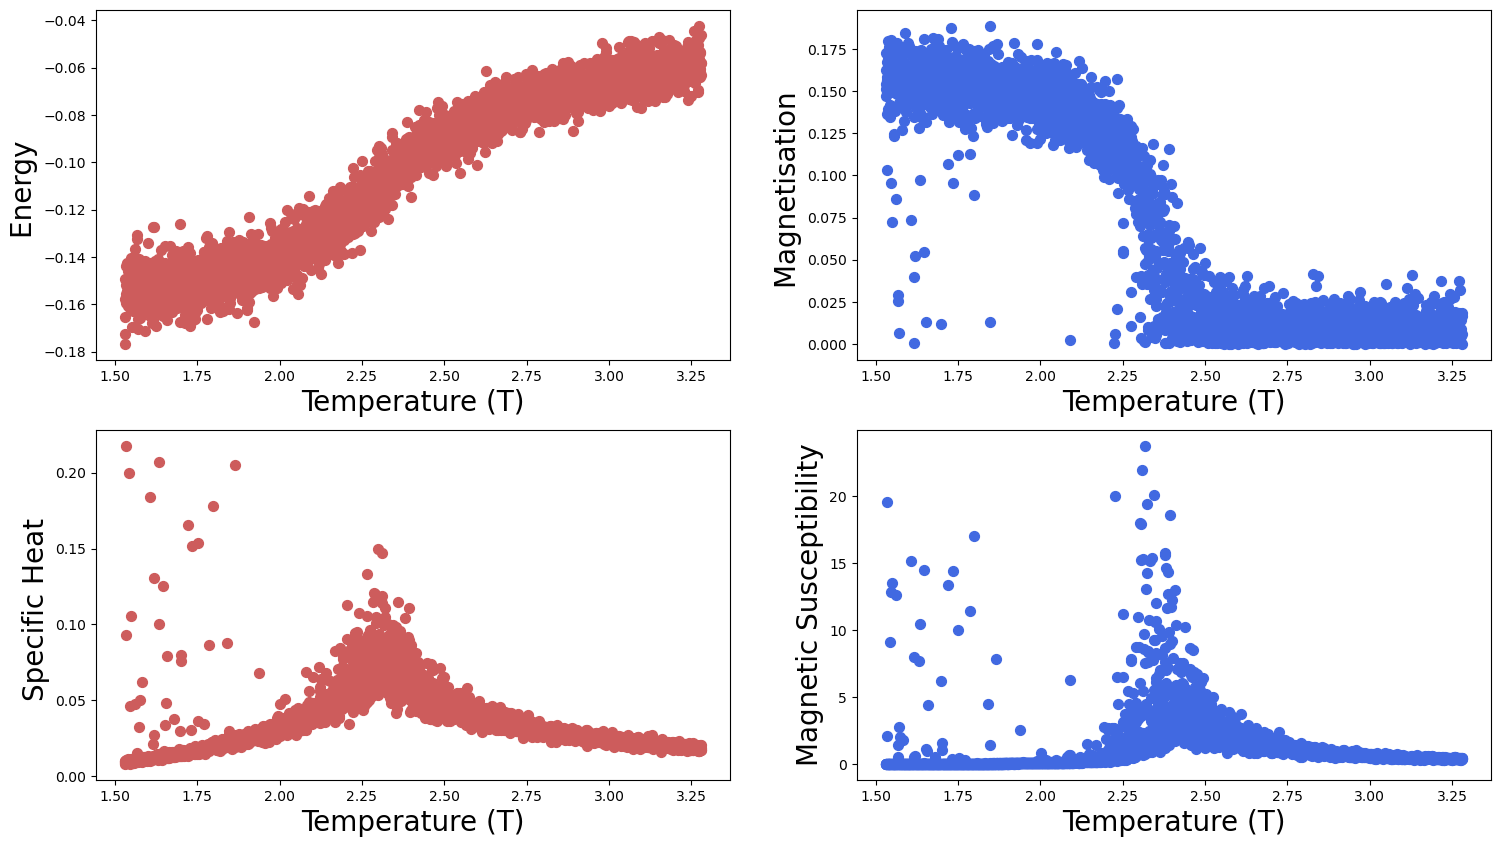

In [57]:
import numpy as np
import matplotlib.pyplot as plt  # For diagnostic plot

# Assuming these are defined: T, nt, N, eqSteps, mcSteps, n1=1.0/mcSteps, n2=n1*n1
# Arrays: E, M, C, X = np.zeros(nt), etc.
M2 = np.zeros(nt)
M4 = np.zeros(nt)

#----------------------------------------------------------------------
#  MAIN PART OF THE CODE
#----------------------------------------------------------------------
for tt in range(nt):
    E1 = M1 = E2 = M2_total = M4_total = 0
    config = initialstate(N)
    iT = 1.0 / T[tt]
    iT2 = iT * iT
    
    for i in range(eqSteps):
        mcmove(config, iT)

    for i in range(mcSteps):
        mcmove(config, iT)
        Ene = calcEnergy(config)
        Mag = calcMag(config)

        E1 += Ene
        M1 += Mag
        M2_total += Mag * Mag
        M4_total += Mag**4
        E2 += Ene * Ene

    E[tt] = n1 * E1
    M[tt] = n1 * M1
    C[tt] = (n1 * E2 - n2 * E1 * E1) * iT2
    X[tt] = (n1 * M2_total - n2 * M1 * M1) * iT
    
    M2[tt] = n1 * M2_total
    M4[tt] = n1 * M4_total

# COMPUTE BINDER & EXTRACT Tc
U = 1 - M4 / (3 * M2**2)

Tc_binder = T[np.argmin(U)]
Tc_susc_peak = T[np.argmax(X)]

print(f"Tc from Binder minimum: {Tc_binder:.4f}")
print(f"Tc from susc peak:     {Tc_susc_peak:.4f}")
print(f"Exact 2D Ising Tc:     2.2690")

# DIAGNOSTIC PLOT
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(T, X, 'b-', label='Susceptibility')
plt.axvline(Tc_susc_peak, color='b', ls='--', label=f'Susc peak {Tc_susc_peak:.3f}')
plt.xlabel('T')
plt.ylabel('X')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(T, U, 'r-', label='Binder U')
plt.axvline(Tc_binder, color='r', ls='--', label=f'Binder min {Tc_binder:.3f}')
plt.axvline(2.269, color='k', ls=':', label='Exact Tc')
plt.xlabel('T')
plt.ylabel('U')
plt.legend()

plt.tight_layout()
plt.show()


f = plt.figure(figsize=(18, 10)); # plot the calculated values    

sp =  f.add_subplot(2, 2, 1 );
plt.scatter(T, E, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');

sp =  f.add_subplot(2, 2, 2 );
plt.scatter(T, abs(M), s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetisation ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(2, 2, 3 );
plt.scatter(T, C, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);  
plt.ylabel("Specific Heat ", fontsize=20);   plt.axis('tight');   

sp =  f.add_subplot(2, 2, 4 );
plt.scatter(T, X, s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetic Susceptibility", fontsize=20);   plt.axis('tight');


In [58]:
import numpy as np
from scipy.optimize import curve_fit

def power_law(T, A, Tc, gamma):
    """chi ~ A * |T - Tc|^(-gamma) for T > Tc"""
    return A * np.abs(T - Tc)**(-gamma)

# After your main loop & U computation
Tc_susc = T[np.argmax(X)]
Tc_binder = T[np.argmin(U)]

print(f"Tc susc peak:  {Tc_susc:.4f}")
print(f"Tc binder min: {Tc_binder:.4f}")

# Find high-T data: T > Tc estimate
mask_susc = T > Tc_susc
mask_binder = T > Tc_binder

if np.sum(mask_susc) < 5 or np.sum(mask_binder) < 5:
    print("Warning: Too few points above Tc for fit")

# Fit 1: Using Tc from susc peak
try:
    popt_susc, _ = curve_fit(power_law, T[mask_susc], X[mask_susc], 
                            p0=[1.0, Tc_susc, 1.75], bounds=([0, 1.5, 0.1], [10, 3.0, 3]))
    A_s, Tc_s, gamma_s = popt_susc
    print(f"Gamma (Tc=susc): {gamma_s:.3f} (A={A_s:.2f})")
except:
    print("Susc fit failed")

# Fit 2: Using Tc from binder min
try:
    popt_binder, _ = curve_fit(power_law, T[mask_binder], X[mask_binder], 
                              p0=[1.0, Tc_binder, 1.75], bounds=([0, 1.5, 0.1], [10, 3.0, 3]))
    A_b, Tc_b, gamma_b = popt_binder
    print(f"Gamma (Tc=binder): {gamma_b:.3f} (A={A_b:.2f})")
except:
    print("Binder fit failed")


Tc susc peak:  2.3178
Tc binder min: 2.6574
Gamma (Tc=susc): 3.000 (A=1.53)
Gamma (Tc=binder): 1.663 (A=0.40)


Critial temp: 2.186378189096914
Gamma: 1.000000000001293
Fit points: 1703
popt = [0.75974593 2.18637819 1.        ]


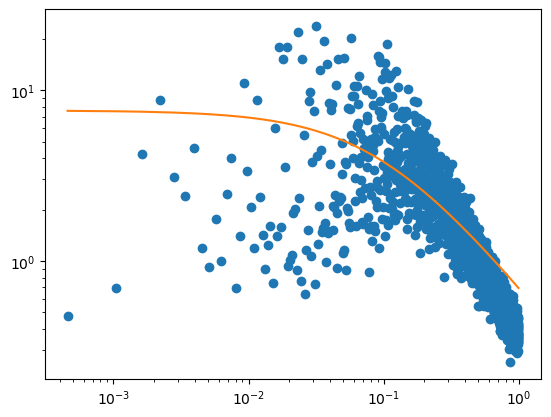

In [60]:
def power_law(T, A, Tc, gamma):
    return A * np.abs(T - Tc)**(-gamma)

frac_low, frac_high = 0.015, 0.08
data_to_fit = (T > Tc_guess * (1 + frac_low)) & (T <= Tc_guess * (1 + frac_high))

data_to_fit = T > Tc_guess
T_fit = T[data_to_fit]
X_fit = X[data_to_fit]

p0 = [np.max(X_fit)*0.5, Tc_guess, 1.75]
bounds = ([0, Tc_guess-0.1, 1], [1e4, Tc_guess+0.02, 2.2])

popt, _ = curve_fit(power_law, T_fit, X_fit, p0, bounds=bounds, maxfev=5000)

print(f"Critial temp: {popt[1]}")
print(f"Gamma: {popt[2]}")
print(f"Fit points: {len(T_fit)}")  # Should be 10+
print(f"popt = {popt}")          # See all 3 values

plt.loglog(T_fit - Tc_guess, X_fit, 'o')
plt.loglog(T_fit - Tc_guess, power_law(T_fit, *popt), '-')
